In [1]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

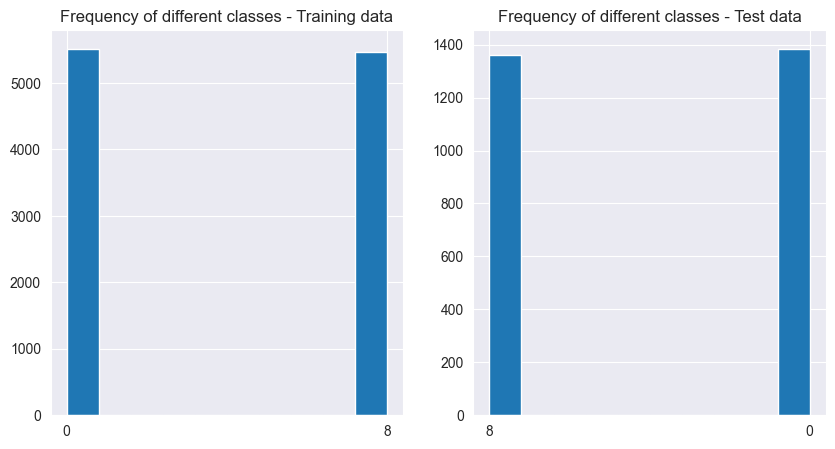

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load MNIST dataset
X, y  = fetch_openml(data_id=554, parser='auto', return_X_y=True) # https://www.openml.org/d/554

# Select only 0s and 8s
num=['0','8']
y1 = y.isin(num)
indices = y1[y1].index
X = X.loc[indices]
y = y.loc[indices]

# Reset index after class selection
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Histogram with the labels in both test and training datasets, to check the Class Balancing
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(y_train);
plt.title('Frequency of different classes - Training data');

plt.subplot(1,2,2)
plt.hist(y_test);
plt.title('Frequency of different classes - Test data');

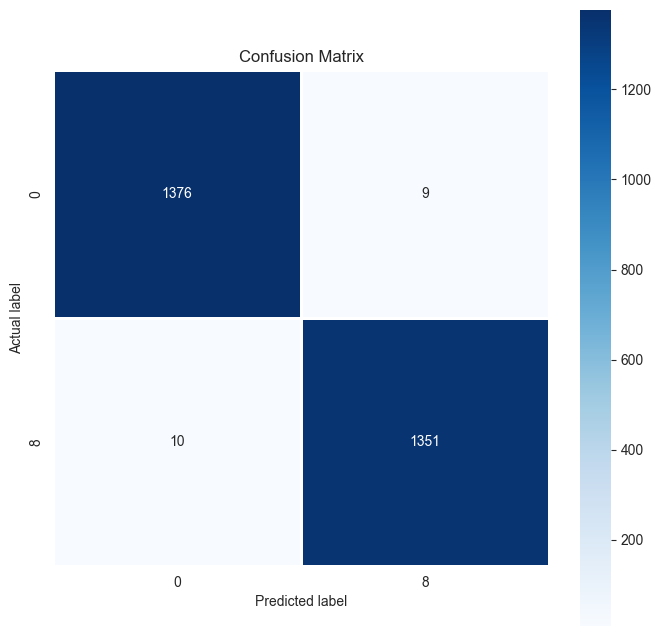

In [12]:
# Learning
clf = LogisticRegression(n_jobs=5, max_iter=10, solver='lbfgs', penalty='l2').fit(X_train, y_train)

# Test score
score = clf.score(X_test, y_test)

# Confusion matrix
predictions = clf.predict(X_test)
cm = metrics.confusion_matrix(y_true=y_test, y_pred=predictions, labels=clf.classes_)

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, linewidths=1, square=True, cmap='Blues', fmt='0.4g');
plt.xlabel('Predicted label')
plt.xticks(ticks=[0.5,1.5],labels=clf.classes_)
plt.ylabel('Actual label')
plt.yticks(ticks=[0.5,1.5],labels=clf.classes_)
plt.title('Confusion Matrix');

In [13]:
# Evaluate the model using classification_report for accuracy, precision, and recall
cr = metrics.classification_report(y_test, predictions, target_names=clf.classes_)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1385
           8       0.99      0.99      0.99      1361

    accuracy                           0.99      2746
   macro avg       0.99      0.99      0.99      2746
weighted avg       0.99      0.99      0.99      2746



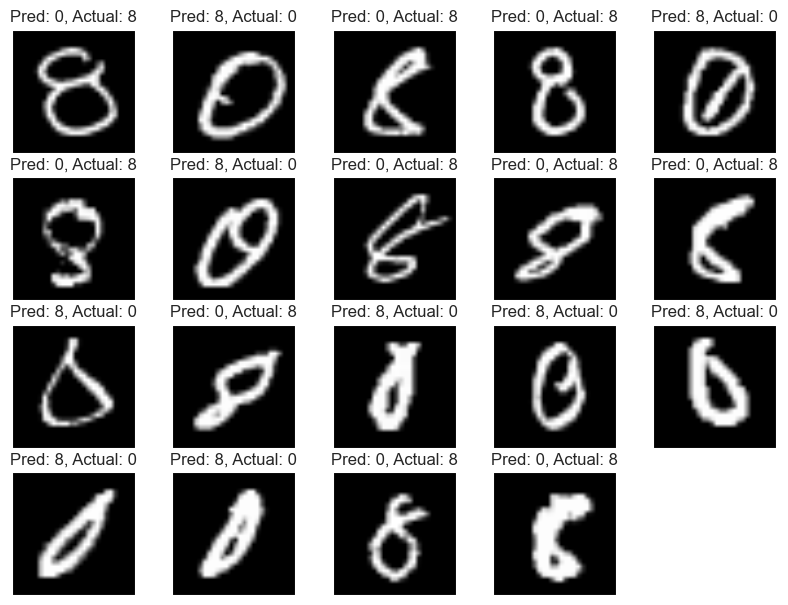

In [15]:
# Inspecting misclassified images, compare predictions with labels to find which images are wrongly classified
index = 0
misclassified_images = []
for label, predict in zip(y_test, predictions):
    if label != predict:
        misclassified_images.append(index)
    index +=1

# Reset index so that X_test and y_test match misclassified_images
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Convert X_test to numpy array
X_test_reset = np.array(X_test)

# Display the first 20 misclassified images
plt.figure(figsize=(10,15))
for plot_index, bad_index in enumerate(misclassified_images[0:20]):
    p = plt.subplot(8,5, plot_index+1)
    p.imshow(X_test_reset[bad_index].reshape(28,28), cmap=plt.cm.gray, interpolation='bilinear')
    p.set_xticks(()); p.set_yticks(()) # remove ticks
    p.set_title(f'Pred: {predictions[bad_index]}, Actual: {y_test[bad_index]}');

### What can you tell about the baseline performance?

1. As can be seen in the classification_report, the accuracy, precision, and recall have very good results as they are all at 99%. This means that the model performs well in the classification task: it is accurate, has high sensitivity and specificity.,
2. To achieve these results I tested with different hyperparameters:
-**solver** = `'lbfgs', 'liblinear', 'saga'`
-**penalty** = `'l2', None, 'l1'`
-**max_iter_** = `1, 5, 10, 20, 50, 100, 1000, 5000, 10000`
The best result was with `max_iter=10, solver='lbfgs', penalty='l2'`; the parameter that most affected the result was `max_iter` and when set above 10 the metrics decreased from 99% to 97% which could suggest overfitting.